In [1]:
# -*- coding: utf-8 -*-
"""
Dataloader program that creates a Pytorch compatible tensor from a raw tab-separated txt file (EP1 MindBigData dataset).
"""
import csv
from numpy.core.numeric import full
import pandas as pd
import numpy as np
import torch


def selectAndAddChannel(eventgrp, name):
    name = str(name)
    channel = eventgrp[eventgrp['channel'] == name]['data'].values
    channel_np = np.fromstring(channel[0], dtype=float, sep=",")[:250]
    return eventgrp, channel_np



# P9, AF7, AF8, and TP10 in a differnet study
def createTensorGroup(eventgrp, transform=True, exclude=[]):
    list_of_channels = ['AF3', 'AF4', 'F7', 'F8', 'F3', 'F4', 'FC5', 'FC6', 'P7', 'P8', 'T7', 'T8', 'O1', 'O2']
    [AF3np, AF4np, F7np, F8np, F3np, F4np, FC5np, FC6np, P7np, P8np, T7np, T8np, O1np, O2np] =\
        [None, None, None, None,None, None, None, None, None, None, None, None, None, None]                                                                                     
    NoneType = type(AF3np)

    exclude = set(exclude)
    # fullChannel = np.empty((1,250))
    if 'AF3' not in exclude:
        eventgrp, AF3np = selectAndAddChannel(eventgrp, 'AF3')
    if 'F7' not in exclude:
        eventgrp, F7np = selectAndAddChannel(eventgrp, 'F7')
    if 'F3' not in exclude:
        eventgrp, F3np = selectAndAddChannel(eventgrp, 'F3')
    if 'FC5' not in exclude:
        eventgrp, FC5np = selectAndAddChannel(eventgrp, 'FC5')
    if 'T7' not in exclude:
        eventgrp, T7np = selectAndAddChannel(eventgrp, 'T7')
    if 'P7' not in exclude:
        eventgrp, P7np = selectAndAddChannel(eventgrp, 'P7')
    if 'T7' not in exclude:
        eventgrp, T7np = selectAndAddChannel(eventgrp, 'T7')
    if 'AF4' not in exclude:
        eventgrp, AF4np = selectAndAddChannel(eventgrp, 'AF4')
    if 'F8' not in exclude:
        eventgrp, F8np = selectAndAddChannel(eventgrp, 'F8')
    if 'F4' not in exclude:
        eventgrp, F4np = selectAndAddChannel(eventgrp, 'F4')
    if 'FC6' not in exclude:
        eventgrp, FC6np = selectAndAddChannel(eventgrp, 'FC6')
    if 'T8' not in exclude:
        eventgrp, T8np = selectAndAddChannel(eventgrp, 'T8')
    if 'P8' not in exclude:
        eventgrp, P8np = selectAndAddChannel(eventgrp, 'P8')
    if 'O1' not in exclude:
        eventgrp, O1np = selectAndAddChannel(eventgrp, 'O1')
    if 'O2' not in exclude:
        eventgrp, O2np = selectAndAddChannel(eventgrp, 'O2')

    list_of_vars = [AF3np, AF4np, F7np, F8np, F3np, F4np, FC5np, FC6np, P7np, P8np, T7np, T8np, O1np, O2np]
    list_of_vars = [x for x in list_of_vars if type(x) != NoneType]  # remove None channels  #todo: the

    fullChannel = torch.tensor(np.vstack(list_of_vars))
    target = int(eventgrp.iloc[0]['code'])
    corrLen = True

    if list(fullChannel.size())[1] < 250:       # remove all instances shorter than 250 events
        print("Short data length")
        corrLen = False
    
    if len(list_of_vars) != (14-len(exclude)):
        print("Fewer channels than expected - ", len(list_of_vars))
        corrLen = False

    elif target < 0:
        print("-1 target val")
        corrLen = False

        
    # print("full channel", fullChannel, "\ntarget", target)

    return fullChannel, target, corrLen


filename = "documents/EP1.01.txt"  # change this line if the location of the file has changed]


def dataLoader(filename, exclude, outpathData, outpathTargets):
    lines = []
    lineMax = 0

    with open(filename) as tsv:
        for line in csv.reader(tsv, dialect="excel-tab"):
            if lineMax == 2000000:  # change this line to select how many examples the dataset to contain
                break
            lines.append(line)
            lineMax += 1

    dF = pd.DataFrame.from_records(lines, columns=['id', 'event', 'device', 'channel', 'code', 'size', 'data'])
    cleanDf = dF.drop(['id', 'device'], axis=1)
    cleanDf['size'] = pd.to_numeric(cleanDf['size'])
    cleanDf['event'] = pd.to_numeric(cleanDf['event'])
    minSize = cleanDf['size'].min()

    events = cleanDf['event'].drop_duplicates().to_numpy()
    numEvents = len(events)

    eventGroups = []
    targets = []
    eventTensors = []

    print("Grouping event channels")
    for event in events:
        eventGroups.append(cleanDf.loc[cleanDf['event'] == event])
        if len(eventGroups[-1]) != 14:
            print("Popped short event with len=" + str(len(eventGroups[-1])))
            eventGroups.pop()
        # print("Event: ", event)

    for eventGroup in eventGroups:
        tensor, target, corrLen = createTensorGroup(eventGroup, transform=True, exclude=exclude)
        if corrLen:
            eventTensors.append(tensor)
            targets.append(target)


    print("dims of the data tensor", eventTensors[0].shape, "type:", type(eventTensors))
    print("num of targets", len(targets), "type:", type(targets))
    fullDataTensor = torch.stack(eventTensors)
    targetTensor = torch.tensor(targets)
    print("shapes are", fullDataTensor.shape, fullDataTensor.shape[1], targetTensor.shape)

    torch.save(fullDataTensor, outpathData)
    torch.save(targetTensor, outpathTargets)
    print("Finished creating a tensor. Exclude=", exclude)


# name of the dataset
exclude = ['O1', 'O2']
outpathData = '/Users/ashrafshaik/scratch/akazako1/10DigData_no' + exclude[0]+exclude[1] + '.pt'
outpathTargets = '/Users/ashrafshaik/scratch/akazako1/10DigTarg_no' + exclude[0]+exclude[1] + '.pt'
dataLoader(filename, exclude, outpathData, outpathTargets)
 
exclude = ['AF3', 'AF4']
outpathData = '/Users/ashrafshaik/scratch/akazako1/10DigData_no' + exclude[0] + exclude[1] + '.pt'
outpathTargets = '/Users/ashrafshaik/scratch/akazako1/new_10DigTarg_no' + exclude[0] + exclude[1] + '.pt'
dataLoader(filename, exclude, outpathData, outpathTargets)


exclude = ['F7', 'F8']
outpathData = '/Users/ashrafshaik/scratch/akazako1/10DigData_no' + exclude[0]+exclude[1] + '.pt'
outpathTargets = '/Users/ashrafshaik/scratch/akazako1/new_10DigTarg_no' + exclude[0]+exclude[1] + '.pt'
dataLoader(filename, exclude, outpathData, outpathTargets)

exclude = ['F3', 'F4',]
outpathData = '/Users/ashrafshaik/scratch/akazako1/10DigData_no' + exclude[0]+exclude[1] + '.pt'
outpathTargets = '/Users/ashrafshaik/scratch/akazako1/new_10DigTarg_no' + exclude[0]+exclude[1] + '.pt'
dataLoader(filename, exclude, outpathData, outpathTargets)

exclude = ['FC5', 'FC6']
outpathData = '/Users/ashrafshaik/scratch/akazako1/10DigData_no' + exclude[0]+exclude[1] + '.pt'
outpathTargets = '/Users/ashrafshaik/scratch/akazako1/new_10DigTarg_no' + exclude[0]+exclude[1] + '.pt'
dataLoader(filename, exclude, outpathData, outpathTargets)

exclude = ['T7', 'T8']
outpathData = '/Users/ashrafshaik/scratch/akazako1/10DigData_no' + exclude[0]+exclude[1] + '.pt'
outpathTargets = '/Users/ashrafshaik/scratch/akazako1/new_10DigTarg_no' + exclude[0]+exclude[1] + '.pt'
dataLoader(filename, exclude, outpathData, outpathTargets)

exclude= ['P7', 'P8']
outpathData = '/Users/ashrafshaik/scratch/akazako1/10DigData_no' + exclude[0]+exclude[1] + '.pt'
outpathTargets = '/Users/ashrafshaik/scratch/akazako1/new_10DigTarg_no' + exclude[0]+exclude[1] + '.pt'
dataLoader(filename, exclude, outpathData, outpathTargets)



Grouping event channels
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1

-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
dims of the data tensor torch.Size([12, 250]) type: <class 'list'>
num of targets 64845 type: <class 'list'>
shapes are torch.Size([64845, 12, 250]) 12 torch.Size([64845])
Finished creating a tensor. Exclude= ['F7', 'F8']
Grouping event channels
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
Short data length
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 target val
-1 t

RuntimeError: Parent directory /scratch/akazako1 does not exist.


 Epoch:  0


/Users/ashrafshaik/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


['acc', 'auc', 'fmeasure']
Training Loss  2772.7614262104034
Test Accuracy of the model on the test set is: 13.331109257714763 %
Test Accuracy of the model on the test set is: 12.905263157894737 %

 Epoch:  1
['acc', 'auc', 'fmeasure']
Training Loss  2741.367828130722
Test Accuracy of the model on the test set is: 14.513761467889909 %
Test Accuracy of the model on the test set is: 15.010526315789473 %

 Epoch:  2
['acc', 'auc', 'fmeasure']
Training Loss  2727.8148527145386
Test Accuracy of the model on the test set is: 14.40533778148457 %
Test Accuracy of the model on the test set is: 13.68421052631579 %

 Epoch:  3
['acc', 'auc', 'fmeasure']
Training Loss  2718.2722034454346
Test Accuracy of the model on the test set is: 16.120100083402836 %
Test Accuracy of the model on the test set is: 15.91578947368421 %

 Epoch:  4
['acc', 'auc', 'fmeasure']
Training Loss  2704.5147421360016
Test Accuracy of the model on the test set is: 16.65888240200167 %
Test Accuracy of the model on the test s

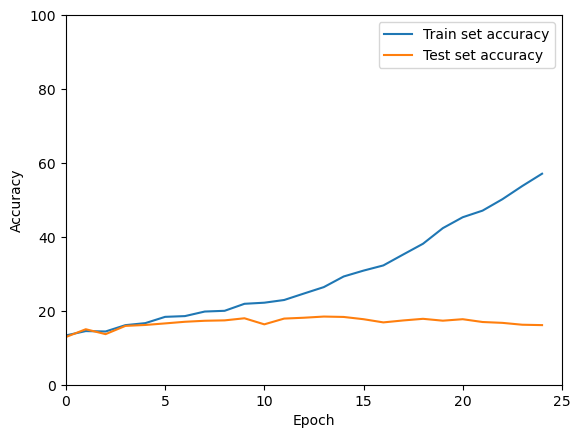


 Epoch:  0
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2774.6574609279633
Test Accuracy of the model on the test set is: 13.74979149291076 %
Test Accuracy of the model on the test set is: 13.263157894736842 %

 Epoch:  1
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2743.0981075763702
Test Accuracy of the model on the test set is: 14.3185988323603 %
Test Accuracy of the model on the test set is: 14.547368421052632 %

 Epoch:  2
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2734.1943175792694
Test Accuracy of the model on the test set is: 15.289407839866556 %
Test Accuracy of the model on the test set is: 15.368421052631579 %

 Epoch:  3
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2725.719004392624
Test Accuracy of the model on the test set is: 15.157631359466222 %
Test Accuracy of the model on the test set is: 14.757894736842106 %

 Epoch:  4
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2721.9641296863556
Test Accuracy of the model on the test set is: 16.

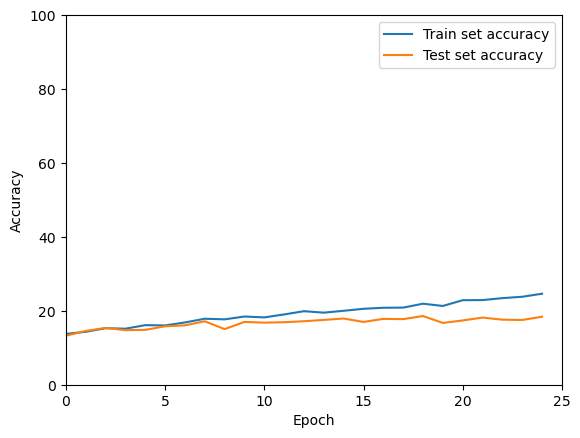


 Epoch:  0
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2773.3370745182037
Test Accuracy of the model on the test set is: 13.292743953294412 %
Test Accuracy of the model on the test set is: 13.578947368421053 %

 Epoch:  1
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2748.988847732544
Test Accuracy of the model on the test set is: 13.974979149291077 %
Test Accuracy of the model on the test set is: 13.284210526315789 %

 Epoch:  2
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2737.6850368976593
Test Accuracy of the model on the test set is: 14.385321100917432 %
Test Accuracy of the model on the test set is: 14.926315789473684 %

 Epoch:  3
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2732.9402327537537
Test Accuracy of the model on the test set is: 14.720600500417014 %
Test Accuracy of the model on the test set is: 14.063157894736841 %

 Epoch:  4
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2728.1580629348755
Test Accuracy of the model on the test set is: 

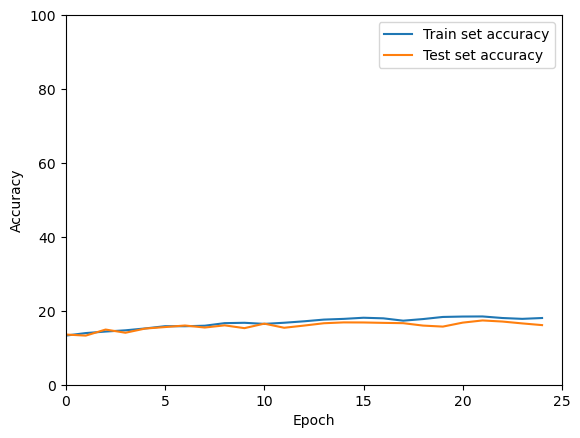


 Epoch:  0
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2774.379167318344
Test Accuracy of the model on the test set is: 13.332777314428691 %
Test Accuracy of the model on the test set is: 13.115789473684211 %

 Epoch:  1
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2748.8635396957397
Test Accuracy of the model on the test set is: 14.153461217681402 %
Test Accuracy of the model on the test set is: 14.589473684210526 %

 Epoch:  2
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2742.593284845352
Test Accuracy of the model on the test set is: 14.041701417848207 %
Test Accuracy of the model on the test set is: 14.31578947368421 %

 Epoch:  3
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2738.951136112213
Test Accuracy of the model on the test set is: 14.707256046705588 %
Test Accuracy of the model on the test set is: 14.063157894736841 %

 Epoch:  4
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2735.8306381702423
Test Accuracy of the model on the test set is: 14.

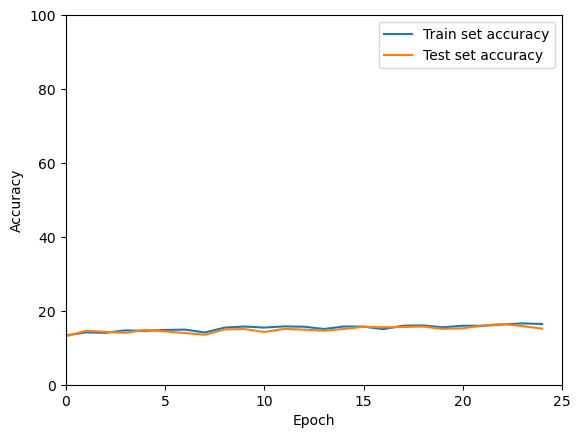


 Epoch:  0
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2776.590573787689
Test Accuracy of the model on the test set is: 12.78231859883236 %
Test Accuracy of the model on the test set is: 12.357894736842105 %

 Epoch:  1
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2757.461615562439
Test Accuracy of the model on the test set is: 13.58465387823186 %
Test Accuracy of the model on the test set is: 13.76842105263158 %

 Epoch:  2
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2751.712517976761
Test Accuracy of the model on the test set is: 13.71976647206005 %
Test Accuracy of the model on the test set is: 14.042105263157895 %

 Epoch:  3
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2747.5250420570374
Test Accuracy of the model on the test set is: 13.748123436196831 %
Test Accuracy of the model on the test set is: 13.76842105263158 %

 Epoch:  4
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2743.6965482234955
Test Accuracy of the model on the test set is: 13.4361

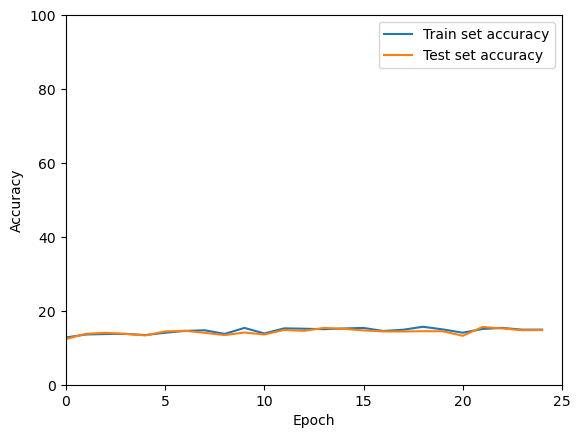


 Epoch:  0
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2777.0178565979004
Test Accuracy of the model on the test set is: 12.835696413678065 %
Test Accuracy of the model on the test set is: 13.452631578947368 %

 Epoch:  1
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2756.968827724457
Test Accuracy of the model on the test set is: 13.863219349457882 %
Test Accuracy of the model on the test set is: 14.042105263157895 %

 Epoch:  2
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2751.367978811264
Test Accuracy of the model on the test set is: 13.032527105921602 %
Test Accuracy of the model on the test set is: 12.08421052631579 %

 Epoch:  3
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2750.3909339904785
Test Accuracy of the model on the test set is: 13.035863219349459 %
Test Accuracy of the model on the test set is: 13.43157894736842 %

 Epoch:  4
Ayy lmao
['acc', 'auc', 'fmeasure']
Training Loss  2750.0269339084625
Test Accuracy of the model on the test set is: 13.

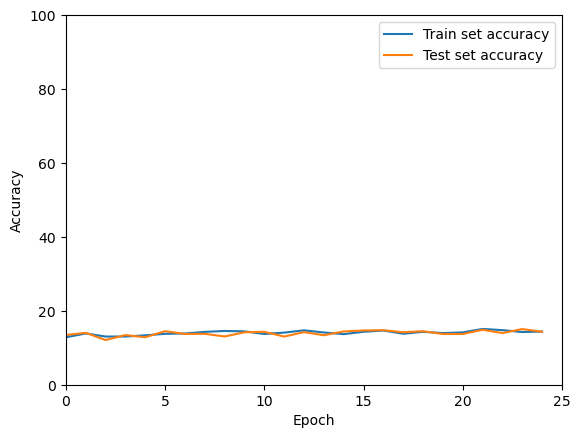

Dropout testing

 Epoch:  0
['acc', 'auc', 'fmeasure']
Training Loss  2774.157208442688
Test Accuracy of the model on the test set is: 13.137614678899082 %
Test Accuracy of the model on the test set is: 12.652631578947368 %

 Epoch:  1
['acc', 'auc', 'fmeasure']
Training Loss  2742.6222236156464
Test Accuracy of the model on the test set is: 14.483736447039199 %
Test Accuracy of the model on the test set is: 14.25263157894737 %

 Epoch:  2
['acc', 'auc', 'fmeasure']
Training Loss  2731.140114545822
Test Accuracy of the model on the test set is: 14.994161801501251 %
Test Accuracy of the model on the test set is: 14.926315789473684 %

 Epoch:  3
['acc', 'auc', 'fmeasure']
Training Loss  2717.14364027977
Test Accuracy of the model on the test set is: 15.192660550458715 %
Test Accuracy of the model on the test set is: 14.673684210526316 %

 Epoch:  4
['acc', 'auc', 'fmeasure']
Training Loss  2702.6888468265533
Test Accuracy of the model on the test set is: 16.989157631359465 %
Test Accurac

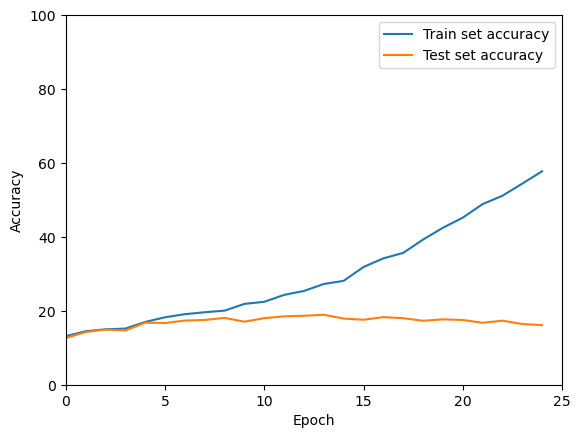


 Epoch:  0
['acc', 'auc', 'fmeasure']
Training Loss  2774.8309047222137
Test Accuracy of the model on the test set is: 13.47789824854045 %
Test Accuracy of the model on the test set is: 12.905263157894737 %

 Epoch:  1
['acc', 'auc', 'fmeasure']
Training Loss  2743.978809595108
Test Accuracy of the model on the test set is: 14.176814011676397 %
Test Accuracy of the model on the test set is: 14.631578947368421 %

 Epoch:  2
['acc', 'auc', 'fmeasure']
Training Loss  2731.4833545684814
Test Accuracy of the model on the test set is: 14.321934945788156 %
Test Accuracy of the model on the test set is: 14.442105263157895 %

 Epoch:  3
['acc', 'auc', 'fmeasure']
Training Loss  2724.1098957061768
Test Accuracy of the model on the test set is: 15.292743953294412 %
Test Accuracy of the model on the test set is: 14.631578947368421 %

 Epoch:  4
['acc', 'auc', 'fmeasure']
Training Loss  2715.122627735138
Test Accuracy of the model on the test set is: 16.011676396997498 %
Test Accuracy of the model

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
The file to run all of our operations for multi class classification.
"""

import torch 
import torch.nn as nn   
from torch.autograd import Variable
import numpy as np
from torch.optim import Adam    #importing an iptimizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from convNet import ConvNet
from thinNet import thinNet
from lowKernelNet import lkNet


import matplotlib.pyplot as plt

# Device configuration
device = torch.device("mps")

# Hyper parameters
num_classes = 10
learning_rate = 0.0003
weight_decay=0.003
batch_size = 50

#load the data
targets = torch.load("/Users/ashrafshaik/scratch/akazako1/new_10DigTarg_noAF3AF4.pt")
data = torch.load("/Users/ashrafshaik/scratch/akazako1/10DigData_noAF3AF4.pt")


#shuffles data, used before each epoch in train model
def shuffleData(inData, labels):
    reshuffleIndex = np.random.permutation(len(inData))
    return torch.tensor(inData.numpy()[reshuffleIndex]), torch.tensor(labels.numpy()[reshuffleIndex]), reshuffleIndex


#normalizes dataset so every EEG channel has a mean of 0 and standard deviation of 1 across all examples.
def setNorm(dataset):
    for i in range(dataset.shape[1]):
        channelMeans = dataset[:,i,:].mean()
        channelStdDev = dataset[:,i,:].std()
        dataset[:,i,:] = (dataset[:,i,:] - channelMeans)/channelStdDev
    return dataset

#Adds Gaussian noise with input standard deviation to dataset.
def addNoise(dataset, stdDev):
    print("Ayy lmao")
    randomAdd = np.random.normal(0, stdDev, dataset.shape)
    noisedData = torch.tensor(dataset.numpy() + randomAdd).type(torch.FloatTensor)
    return noisedData

# Define the loss function and optimizer
loss_fn = nn.NLLLoss()
net = ConvNet(num_classes=num_classes,dropout=0.0).to(device)
optimizer = Adam(net.parameters(), lr=learning_rate, weight_decay = weight_decay)


data = setNorm(data)   #normalize the data
X_train = data[:60000]   # perform the text/train split 
Y_train = targets[:60000]
X_test = data[60000:]
Y_test = targets[60000:]

"""
Training function for our model, randomizes dataset on each epoch and adds noise if noise param !=0. 
    net: the model to train and test
    optimizer: specified optimizer
    num_epoch: number of epoch to run during training 
    noise: proportion of Gaussian noise with input standard deviation to dataset
    returns lists of accuracy at each epoch on training and test sets.
"""
def trainModel(net, optimizer, num_epochs, noise):
    trainAcc = []
    testAcc = []
    for epoch in range(num_epochs):
        print("\n Epoch: ", epoch)
        
        X_epoch, Y_epoch, shufPerm = shuffleData(X_train, Y_train) 
        
        if noise != 0:
            X_epoch = addNoise(X_epoch, noise)
            X_epoch = setNorm(X_epoch)
        running_loss = 0.0
        for i in range(int(len(X_epoch)/batch_size-1)):
            s = i*batch_size
            e = i*batch_size+batch_size
    
            inputs = X_epoch[s:e].unsqueeze(1).type(torch.FloatTensor)
            labels = Y_epoch[s:e]
            inputs, labels = Variable(inputs.to(device)), Variable(labels.type(torch.LongTensor).to(device))
        
            optimizer.zero_grad()        
            outputs = net(inputs)       
            loss= loss_fn(outputs, labels)
            loss.backward()
    
            optimizer.step()
    
            running_loss += float(loss.item())
            del loss
            del labels
            del inputs 
            del outputs 
        params = ["acc", "auc", "fmeasure"]
        print(params)
        print("Training Loss ", running_loss)
        trainAcc.append(testModel(net, X_train, Y_train))
        testAcc.append(testModel(net, X_test, Y_test))
    return trainAcc, testAcc
    


""" 
Model testing function, prints accuracy of classifier on input test data and labels
    net: trained model to test
    X_test, Y_test: data and labels, respectively
"""
def testModel(net, X_test, Y_test):
    with torch.no_grad():
        test_loss = 0.0
        test_total = 0
        for i in range(int(len(X_test)/batch_size-1)):
            s = i*batch_size
            e = i*batch_size+batch_size
    
            inputs = X_test[s:e].unsqueeze(1).type(torch.FloatTensor)
            labels = Y_test[s:e]
            outputs = net(inputs.to(device))
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.to(device='cpu')
            total = len(labels)
            correct = (predicted == labels).sum().item()
            test_loss += correct
            test_total += total
            del inputs
            del labels
            del _
    print('Test Accuracy of the model on the test set is: {} %'.format(100 * test_loss / test_total))
    return (100 * test_loss / test_total)

"""
Generates a confusion matrix for an input net with the input data and labels
    net: trained model to test
    X_test, Y_test: data and labels, respectively
    returns a list of predictions, as well the the confusion matrix
"""
def generateConfusionMatrix(net, X_test, Y_test):
    preds = np.array([], dtype=int)
    predLen = 0
    with torch.no_grad():
        for i in range(int(len(X_test)/batch_size-1)):
            s = i*batch_size
            e = i*batch_size+batch_size
            predLen += batch_size
            inputs = X_test[s:e].unsqueeze(1).type(torch.FloatTensor)
            outputs = net(inputs.to(device))
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.to(device='cpu').numpy()
            preds = np.concatenate((preds, predicted))
    return preds, confusion_matrix(Y_test.numpy()[:predLen], preds, normalize='true')

"""
Produces validation curves for each dropout probability in params; 
trains a model with that value, and prints the resulting validation curve 
    numEpochs: number of epoch to run
    params: other parameters (learning_rate, weight_decay) to examine
"""
def genDropoutValCurves(numEpochs, params):
    print("Dropout testing")
    for i in range(len(params)):
        net = ConvNet(num_classes=num_classes,dropout=params[i]).to(device)
        optimizer = Adam(net.parameters(), lr=learning_rate, weight_decay = weight_decay)
        trAcc, teAcc = trainModel(net, optimizer, numEpochs, 0.0)
        plt.plot(range(numEpochs), trAcc, label='Train set accuracy')
        plt.plot(range(numEpochs), teAcc, label='Test set accuracy')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.xlim(0,numEpochs)
        plt.ylim(0,100)
        plt.legend()
        plt.show()

""" 
Produces validation curves for each noise value in params; trains a model with 
that value,and prints the resulting validation curve 
    numEpochs: number of epoch to run
    params: other parameters (learning_rate, weight_decay) to examine
""" 
def genNoiseValCurves(numEpochs, params):
    for i in range(len(params)):
        net = ConvNet(num_classes=num_classes,dropout=0.0).to(device)
        optimizer = Adam(net.parameters(), lr=learning_rate, weight_decay = weight_decay)
        trAcc, teAcc = trainModel(net, optimizer, numEpochs, params[i])
        plt.plot(range(numEpochs), trAcc, label='Train set accuracy')
        plt.plot(range(numEpochs), teAcc, label='Test set accuracy')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.xlim(0,numEpochs)
        plt.ylim(0,100)
        plt.legend()
        plt.show()

        
""" 
Calculates precision, recall and f-scores for the model
    net: trained model to test
    X_test, Y_test: data and labels, respectively
    returns  precision, recall and f-scores for the model
"""        
def genScores(net, X_test, Y_test):
    preds, _ = generateConfusionMatrix(net, X_test, Y_test)
    return precision_recall_fscore_support(Y_test.numpy(), preds, average='micro')


def genTSplots(ts, title):
    plt.rc('font', size=12)
    fig, ax = plt.subplots(figsize=(10, 6))

    # Specify how our lines should look
    ax.plot(range(len(ts)), ts, color='tab:orange')

    # Same as above
    ax.set_xlabel('time')
    ax.set_ylabel('Normalized Amplitude')
    ax.set_title(title)
    ax.grid(True)
    plt.show()

# Save the model checkpoint
torch.save(net.state_dict(), '/Users/ashrafshaik/scratch/akazako1/model.ckpt')
        
genNoiseValCurves(25, [0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
genDropoutValCurves(25, [0.0,0.1,0.2,0.3,0.4,0.5])